<a href="https://www.kaggle.com/code/thejades/525-project?scriptVersionId=113965934" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename)) # printout is to big to display every time
        print('', end='')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# guide followed

https://www.tensorflow.org/tutorials/images/classification

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
#/kaggle/input/vegetable-image-dataset/Vegetable Images/validation/Broccoli/

In [4]:
import pathlib
data_dir = pathlib.Path(r"/kaggle/input/vegetable-image-dataset/Vegetable Images/")

image_count = len(list(data_dir.glob('*/*/*.jpg')))
print(image_count)

21000


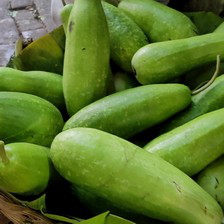

In [5]:
veg = list(data_dir.glob(f'*/Bottle_Gourd/*'))
PIL.Image.open(str(veg[0]))

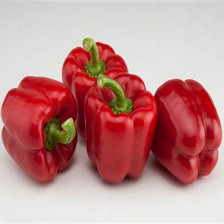

In [6]:
veg = list(data_dir.glob(f'*/Capsicum/*'))
PIL.Image.open(str(veg[0]))

# loading data to Keras utility

In [7]:
batch_size = 32  # can test varrying this value
img_height = 224
img_width = 224

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  pathlib.Path(r"/kaggle/input/vegetable-image-dataset/Vegetable Images/train"),
  validation_split=None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15000 files belonging to 15 classes.


2022-12-16 07:04:33.858329: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-16 07:04:33.972541: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-16 07:04:33.973316: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-16 07:04:33.976469: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  pathlib.Path(r"/kaggle/input/vegetable-image-dataset/Vegetable Images/validation"),
  validation_split=None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3000 files belonging to 15 classes.


In [10]:
class_names = train_ds.class_names
print(class_names)

['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']


# visualize the data

2022-12-16 07:04:36.821768: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


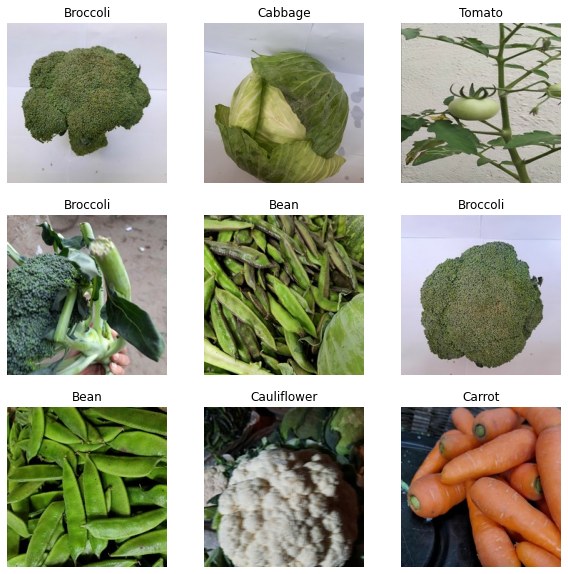

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(15000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
normalization_layer = layers.Rescaling(1./255)

In [15]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))
del normalized_ds

2022-12-16 07:04:48.807385: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 147 of 15000
2022-12-16 07:04:58.789835: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 299 of 15000
2022-12-16 07:05:08.780919: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 450 of 15000


0.0 0.9568628


2022-12-16 07:05:09.593269: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


# A basic Keras model

In [16]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.3),
  ]
)

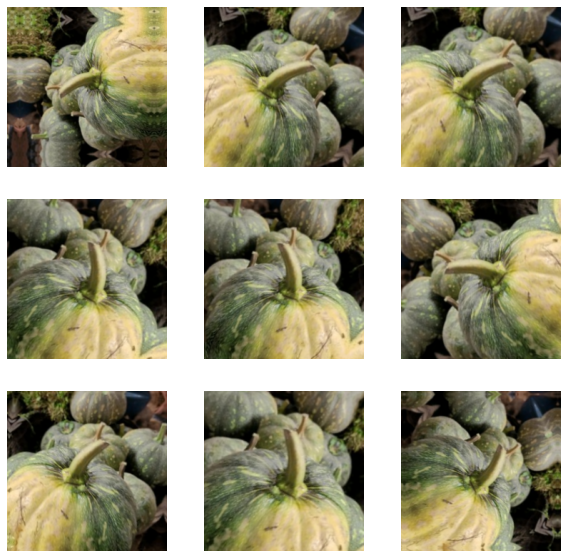

In [17]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [18]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)       

In [21]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [22]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


2022-12-16 07:05:13.003583: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


469/469 [==============================] - 25s 38ms/step - loss: 1.4601 - accuracy: 0.5124 - val_loss: 0.9112 - val_accuracy: 0.6930
Epoch 2/20
469/469 [==============================] - 10s 22ms/step - loss: 0.8102 - accuracy: 0.7293 - val_loss: 0.7994 - val_accuracy: 0.7363
Epoch 3/20
469/469 [==============================] - 10s 22ms/step - loss: 0.5763 - accuracy: 0.8065 - val_loss: 0.3998 - val_accuracy: 0.8647
Epoch 4/20
469/469 [==============================] - 10s 22ms/step - loss: 0.4742 - accuracy: 0.8430 - val_loss: 0.4790 - val_accuracy: 0.8420
Epoch 5/20
469/469 [==============================] - 10s 22ms/step - loss: 0.4035 - accuracy: 0.8666 - val_loss: 0.3242 - val_accuracy: 0.8990
Epoch 6/20
469/469 [==============================] - 10s 22ms/step - loss: 0.3337 - accuracy: 0.8900 - val_loss: 0.2609 - val_accuracy: 0.9183
Epoch 7/20
469/469 [==============================] - 10s 22ms/step - loss: 0.3071 - accuracy: 0.9035 - val_loss: 0.2665 - val_accuracy: 0.9127
Epo

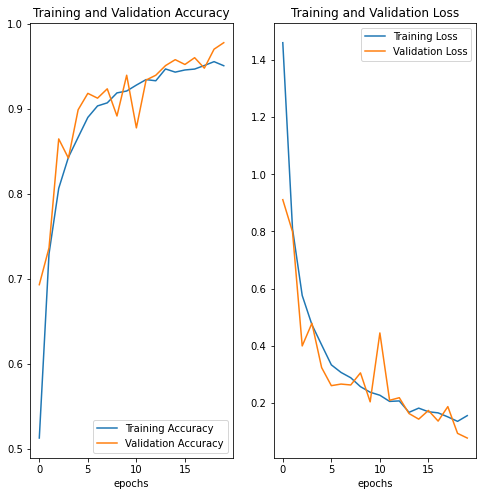

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('epochs')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epochs')
plt.show()

# Predict New Data (testing on unseen data)

This image most likely belongs to Cucumber with a 67.13 percent confidence.
tf.Tensor(
[2.2692068e-06 2.6612235e-05 3.1140378e-01 8.7935328e-03 1.4575386e-06
 1.9248207e-04 1.5559884e-06 1.9372419e-10 8.4354851e-06 6.7133760e-01
 8.1484169e-03 2.4736528e-06 1.6969978e-05 1.7478797e-07 6.4273714e-05], shape=(15,), dtype=float32)


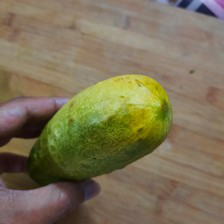

In [24]:
import random

veg = random.choice(list(data_dir.glob('test/*/*.jpg')))

img = tf.keras.utils.load_img(
    veg, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

print(score)

PIL.Image.open(veg)

In [25]:
def predict_image(path, print_out=True):

    img = tf.keras.utils.load_img(
        test_img_path, target_size=(img_height, img_width)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    if print_out:
        print(
            "This image most likely belongs to {} with a {:.2f} percent confidence."
            .format(class_names[np.argmax(score)], 100 * np.max(score))
        )

    PIL.Image.open(test_img_path)
    
    return class_names[np.argmax(score)], np.max(score)

This image most likely belongs to Pumpkin with a 85.41 percent confidence.


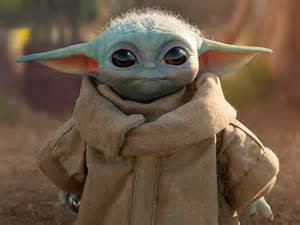

In [26]:
test_img_path = r'/kaggle/input/veg-images-personal-images/th-2341954804.jpg'
predict_image(test_img_path)
PIL.Image.open(test_img_path)

# test on unseen data large dataset

In [27]:
os.listdir(r'/kaggle/input/vegetable-image-dataset/Vegetable Images/test')

['Broccoli',
 'Capsicum',
 'Bottle_Gourd',
 'Radish',
 'Tomato',
 'Brinjal',
 'Pumpkin',
 'Carrot',
 'Papaya',
 'Cabbage',
 'Bitter_Gourd',
 'Cauliflower',
 'Bean',
 'Cucumber',
 'Potato']

In [28]:
for test_veg in os.listdir(r'/kaggle/input/vegetable-image-dataset/Vegetable Images/test'):
    predictions_list = []

    for test_img_path in list(data_dir.glob(f'test/{test_veg}/*.jpg')):
        img = tf.keras.utils.load_img(
        test_img_path, target_size=(img_height, img_width)
        )
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch

        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])
    
        if class_names[np.argmax(score)] == test_veg:
            predictions_list.append(1)
        else:
            predictions_list.append(0)
        
    print(f'{test_veg} has an accuracy of: {sum(predictions_list)/len(predictions_list)}')

Broccoli has an accuracy of: 0.96
Capsicum has an accuracy of: 0.985
Bottle_Gourd has an accuracy of: 0.98
Radish has an accuracy of: 1.0
Tomato has an accuracy of: 0.97
Brinjal has an accuracy of: 0.975
Pumpkin has an accuracy of: 0.97
Carrot has an accuracy of: 0.985
Papaya has an accuracy of: 0.925
Cabbage has an accuracy of: 0.99
Bitter_Gourd has an accuracy of: 0.975
Cauliflower has an accuracy of: 0.98
Bean has an accuracy of: 0.99
Cucumber has an accuracy of: 0.99
Potato has an accuracy of: 1.0


In [29]:
for test_veg in os.listdir(r'/kaggle/input/vegetable-image-dataset/Vegetable Images/validation'):
    predictions_list = []

    for test_img_path in list(data_dir.glob(f'validation/{test_veg}/*.jpg')):
        img = tf.keras.utils.load_img(
        test_img_path, target_size=(img_height, img_width)
        )
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch

        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])
    
        if class_names[np.argmax(score)] == test_veg:
            predictions_list.append(1)
        else:
            predictions_list.append(0)
        
    print(f'{test_veg} has an accuracy of: {sum(predictions_list)/len(predictions_list)}')

Broccoli has an accuracy of: 0.95
Capsicum has an accuracy of: 1.0
Bottle_Gourd has an accuracy of: 0.975
Radish has an accuracy of: 0.98
Tomato has an accuracy of: 0.97
Brinjal has an accuracy of: 0.99
Pumpkin has an accuracy of: 0.96
Carrot has an accuracy of: 1.0
Papaya has an accuracy of: 0.935
Cabbage has an accuracy of: 0.995
Bitter_Gourd has an accuracy of: 0.985
Cauliflower has an accuracy of: 0.98
Bean has an accuracy of: 1.0
Cucumber has an accuracy of: 0.995
Potato has an accuracy of: 1.0


In [30]:
for test_veg in os.listdir(r'/kaggle/input/vegetable-image-dataset/Vegetable Images/train'):
    predictions_list = []

    for test_img_path in list(data_dir.glob(f'train/{test_veg}/*.jpg')):
        img = tf.keras.utils.load_img(
        test_img_path, target_size=(img_height, img_width)
        )
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch

        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])
    
        if class_names[np.argmax(score)] == test_veg:
            predictions_list.append(1)
        else:
            predictions_list.append(0)
        
    print(f'{test_veg} has an accuracy of: {sum(predictions_list)/len(predictions_list)}')

Broccoli has an accuracy of: 0.972
Capsicum has an accuracy of: 0.997
Bottle_Gourd has an accuracy of: 0.99
Radish has an accuracy of: 0.997
Tomato has an accuracy of: 0.981
Brinjal has an accuracy of: 0.987
Pumpkin has an accuracy of: 0.991
Carrot has an accuracy of: 0.993
Papaya has an accuracy of: 0.94
Cabbage has an accuracy of: 0.989
Bitter_Gourd has an accuracy of: 0.994
Cauliflower has an accuracy of: 0.99
Bean has an accuracy of: 0.998
Cucumber has an accuracy of: 0.996
Potato has an accuracy of: 0.995
